In [ ]:
#default_exp interpret.gradcam

# GradCam

> [Grad-CAM](https://arxiv.org/abs/1610.02391) aka Gradient-weighted Class Activation Mapping "uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept". <br><br>
This module allows you to inspect any layer of your model via a simple `Learner.gradcam(...)` call <br><br>
Code heavily inspired by [Chapter 18](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb) of Jeremy Howard and Sylvain Gugger's [`fastbook`](https://github.com/fastai/fastbook)

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
#hide
import fastai
print(fastai.__version__)

2.0.16


In [ ]:
#export
from fastai.vision.all import *
from typing import List, Tuple, Callable, Union, Optional, Any, Dict

In [ ]:
#hide
from cinemanet.train.data_handler import *

learn = load_learner("../framing-1.pkl")
learn.model[1] = nn.Sequential(*[learn.model[0][-1], *learn.model[1]])
learn.model[0][-1] = Identity()

dhandler = (
    DataHandler("../../CinemaNet-Training/exports/datasets/shot-framing.json",
                is_multilabel=False, verbose=False)
    .get_dataset_df('train-clean', 'valid-clean')
    .filter_dataset()
    .setup_dls(batch_size=32)
)

learn.dls = dhandler.dls

/home/synopsis/git/CinemaNet-Training/cinemanet/train/data_handler.py:306: UserWarning: No batch transforms have been passed. Training with NO data augmentation
  warnings.warn("No batch transforms have been passed. Training with NO data augmentation")


In [ ]:
#hide
torch.cuda.set_device(0)
torch.cuda.get_device_name()

'GeForce RTX 3090'

<h3> Steps for plotting GradCAM </h3>

<br>

1. Create your `Learner`'s `test_dl` w.r.t. one image and label
2. Compute activations (forward pass) and gradients (backward pass)
3. Compute gradcam-map (7x7 in this case)
    1. Take mean of gradients across feature maps: `(1280, 7, 7) --> (1280, 1, 1)`
    2. Multiply mean * activation: `(1280,1,1) * (1280,7,7) --> (1280,7,7)`
    3. Sum (B) across all 1280 channels: `(1280,7,7) --> (7,7)`
4. Plot gradcam-map over the image

These steps are shown below one by one and later combined in a `Learner.gradcam` call

In [ ]:
#export
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, inp, out):  self.stored = out.detach().clone()
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.hook.remove()

class HookBwd():
    def __init__(self,m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, model, grad_in, grad_out): self.stored = grad_out[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.hook.remove()

#### 1. Create your `Learner`'s `test_dl` w.r.t. one image and label

In [ ]:
def create_test_img(learn, f, return_img=True):
    img = PILImage.create(f)
    x = first(learn.dls.test_dl([f]))
    x = x[0]
    if return_img: return img,x
    return x

In [ ]:
path_imgs = '../assets/imgs/'
f = get_image_files(path_imgs)[2]

img,x = create_test_img(learn, f)
label = np.random.choice(learn.dls.vocab)
label

'06-medium-close-up'

#### 2. Compute activations (forward pass) and gradients (backward pass)

In [ ]:
#export
def to_cuda(*args): [o.cuda() for o in args]

In [ ]:
#export
def get_label_idx(learn:Learner, preds:torch.Tensor,
                  label:Union[str,int,None]) -> Tuple[int,str]:
    """Either:
    * Get the label idx of a specific `label`
    * Get the max pred using `learn.loss_func.decode` and `learn.loss_func.activation`
        * Only works for `softmax` activations as the backward pass requires a scalar index
        * Throws a `RuntimeError` if the activation is a `sigmoid` activation
    """
    if label is not None:
        # if `label` is a string, check that it exists in the vocab
        # and return the label's index
        if isinstance(label,str):
            if not label in learn.dls.vocab: raise ValueError(f"'{label}' is not part of the Learner's vocab: {learn.dls.vocab}")
            return learn.dls.vocab.o2i[label], label
        # if `label` is an index, return itself
        elif isinstance(label,int): return label, learn.dls.vocab[label]
        else: raise TypeError(f"Expected `str`, `int` or `None`, got {type(label)} instead")
    else:
        # if no `label` is specified, check that `learn.loss_func` has `decodes`
        # and `activation` implemented, run the predictions through them,
        # then check that the output length is 1. If not, the activation must be
        # sigmoid, which is incompatible
        if not hasattr(learn.loss_func, 'activation') or\
           not hasattr(learn.loss_func, 'decodes'):
            raise NotImplementedError(f"learn.loss_func does not have `.activation` or `.decodes` methods implemented")
        decode_pred = compose(learn.loss_func.activation, learn.loss_func.decodes)
        label_idx   = decode_pred(preds)
        if len(label_idx) > 1:
            raise RuntimeError(f"Output label idx must be of length==1. If your loss func has a sigmoid activation, please specify `label`")
        return label_idx, learn.dls.vocab[label_idx][0]

In [ ]:
#hide
from nbdev.showdoc import show_doc

In [ ]:
#export
def get_target_layer(learn: Learner,
                     target_layer:Union[nn.Module, Callable, None]) -> nn.Module:
    if target_layer is None:
        if has_pool_type(learn.model[0]):
            warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")  
        return learn.model[0]
    elif isinstance(target_layer, nn.Module):
        return target_layer
    elif callable(target_layer):
        return target_layer(learn.model)

In [ ]:
#export
def compute_gcam_items(learn: Learner,
                       x: TensorImage,
                       label: Union[str,int,None] = None,
                       target_layer: Union[nn.Module, Callable, None] = None
                      ) -> Tuple[torch.Tensor]:
    """Compute gradient and activations of `target_layer` of `learn.model`
    for `x` with respect to `label`.
    
    If `target_layer` is None, then it is set to `learn.model[:-1]`
    """
    to_cuda(learn.model, x)
    target_layer = get_target_layer(learn, target_layer)
    with HookBwd(target_layer) as hook_g:
        with Hook(target_layer) as hook:
            preds       = learn.model.eval()(x)
            activations = hook.stored
            label_idx, label = get_label_idx(learn,preds,label)
            #print(preds.shape, label, label_idx)
            #print(preds)
        preds[0, label_idx].backward()
        gradients = hook_g.stored

    preds = getattr(learn.loss_func, 'activation', noop)(preds)

    # remove leading batch_size axis
    gradients   = gradients  [0]
    activations = activations[0]
    preds       = preds.detach().cpu().numpy().flatten()
    return gradients, activations, preds, label

In [ ]:
gradients, activations, preds, label = compute_gcam_items(learn, x, label=None, target_layer=None)

gradients.shape, activations.shape, preds.shape, label

(torch.Size([1280, 7, 7]), (1280, 7, 7), (9,), '04-medium-long')

#### 3. Compute gradcam-map

In [ ]:
#export
def compute_gcam_map(gradients, activations) -> torch.Tensor:
    """Take the mean of `gradients`, multiply by `activations`,
    sum it up and return a GradCAM feature map
    """
    # Mean over the feature maps. If you don't use `keepdim`, it returns
    # a value of shape (1280) which isn't amenable to `*` with the activations
    gcam_weights = gradients.mean(dim=[1,2], keepdim=True) # (1280,7,7)   --> (1280,1,1)
    gcam_map     = (gcam_weights * activations) # (1280,1,1) * (1280,7,7) --> (1280,7,7)
    gcam_map     = gcam_map.sum(0)              # (1280,7,7) --> (7,7)
    return gcam_map

In [ ]:
gcam_map = compute_gcam_map(gradients, activations)
gcam_map.shape

(7, 7)

#### 4. Plot gradcam-map over the image

In [ ]:
#export
import PIL
def plt2pil(fig) -> PIL.Image.Image:
    """Convert a matplotlib `figure` to a PILImage"""
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    pil_img = PIL.Image.open(buf).convert('RGB')
    plt.close('all')
    return pil_img

def plt_decoded(learn, x, ctx):
    'Processed tensor --> plottable image, return `extent`'
    x_decoded = TensorImage(learn.dls.train.decode((x,))[0][0])
    extent = (0, x_decoded.shape[1], x_decoded.shape[2], 0)
    x_decoded.show(ctx=ctx)
    return extent
    
def plot_gcam(learn, img:PILImage, x:tensor, gcam_map:tensor,
              full_size=True, alpha=0.6, dpi=100,
              interpolation='bilinear', cmap='magma', **kwargs):
    'Plot the `gcam_map` over `img`'
    fig,ax = plt.subplots(dpi=dpi, **kwargs)
    if full_size:
        extent = (0, img.width,img.height, 0)
        show_image(img, ctx=ax)
    else:
        extent = plt_decoded(learn, x, ax)

    show_image(gcam_map.detach().cpu(), ctx=ax,
               alpha=alpha, extent=extent,
               interpolation=interpolation, cmap=cmap)
    
    return plt2pil(fig)

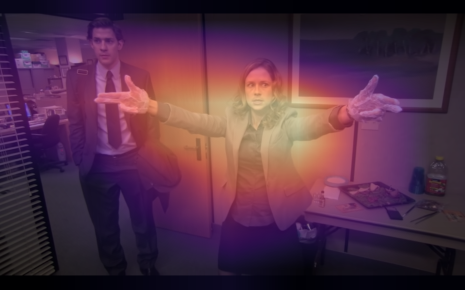

In [ ]:
plot_gcam(learn, img, x, gcam_map, full_size=True, dpi=100)

In [ ]:
#export
from palettable.colorbrewer.diverging import RdYlBu_10_r
from fastai_amalgam.utils import *

@patch
def gradcam(self: Learner,
            item: Union[PILImage, os.PathLike],
            target_layer: Union[nn.Module, Callable, None] = None,
            labels: Union[str,List[str], int,List[int], None] = None,
            show_original=False, img_size=None, alpha=0.5,
            cmap = RdYlBu_10_r.mpl_colormap,
            font_path=None, font_size=None, grid_ncol=4,
            **kwargs
           ):
    """Plot Grad-CAMs of all specified `labels` with respect to `target_layer`
    Key Args:
    * `item`: a `PILImage` or path to a file. Use like you would `Learner.predict`
    * `target_layer`: The target layer w.r.t which the Grad-CAM is produced
                      Can be a function that returns a specific layer of the model
      or also a direct reference such as `learn.model[0][2]`. If `None`, 
      defaults to `learn.model[0]`
    * `labels`: A string, int index, or list of the same w.r.t which the Grad-CAM
                must be plotted. If `None`, the top-prediction is plotted if the
      model uses a Softmax activation, else it must be specified.
    * `show_original`: Show the original image without the heatmap overlay
    * `font_path`: (Optional, recommended) Path to a `.ttf` font to render the text
    * `font_size`: Size of the font rendered on the image
    * `grid_ncol`: No. of columns to be shown. By default, all maps are shown in one row
    """
    dl = self.dls.test_dl([item])
    x = detuplify(first(dl))
    
    
    if not isinstance(labels, list): labels=[labels]
    if isinstance(item, PILImage): img = item
    else: img = PILImage.create(item)
    if img_size is not None: img=img.resize(img_size)
    if grid_ncol is None: grid_ncol = 1+len(labels) if show_original else len(labels)
        
    gcams = defaultdict()
    
    results = []
    for label in labels:
        grads, acts, preds, _label = compute_gcam_items(self, x, label, target_layer)
        gcams[label] = compute_gcam_map(grads, acts)
        preds_dict = {l:pred for pred,l in zip(preds, self.dls.vocab)}
        pred_img = plot_gcam(self, img, x, gcams[label], alpha=alpha, cmap=cmap)
        pred_img.draw_labels(f"{_label}: {preds_dict[_label]* 100:.02f}%",
                             font_path=font_path, font_size=font_size, location="top")
        results.append(pred_img)
    if show_original:
        img = img.resize(results[0].size)
        results.insert(0, img.draw_labels("Original", font_path=font_path, font_size=font_size, location="top"))
    return make_img_grid(results, img_size=None, ncol=grid_ncol)

In [ ]:
show_doc(Learner.gradcam)

<h4 id="Learner.gradcam" class="doc_header"><code>Learner.gradcam</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.gradcam</code>(**`item`**:`Union`\[`PILImage`, [`PathLike`](/fastai_amalgam/interpret_gradcam.html#PathLike)\], **`target_layer`**:`Union`\[`Module`, `Callable`, `NoneType`\]=*`None`*, **`labels`**:`Union`\[`str`, `List`\[`str`\], `int`, `List`\[`int`\], `NoneType`\]=*`None`*, **`show_original`**=*`False`*, **`img_size`**=*`None`*, **`alpha`**=*`0.5`*, **`cmap`**=*`<matplotlib.colors.LinearSegmentedColormap object at 0x7fbc2b90ef10>`*, **`font_path`**=*`None`*, **`font_size`**=*`None`*, **`grid_ncol`**=*`4`*, **\*\*`kwargs`**)

```
Plot Grad-CAMs of all specified `labels` with respect to `target_layer`
Key Args:
* `item`: a `PILImage` or path to a file. Use like you would `Learner.predict`
* `target_layer`: The target layer w.r.t which the Grad-CAM is produced
                  Can be a function that returns a specific layer of the model
  or also a direct reference such as `learn.model[0][2]`. If `None`, 
  defaults to `learn.model[0]`
* `labels`: A string, int index, or list of the same w.r.t which the Grad-CAM
            must be plotted. If `None`, the top-prediction is plotted if the
  model uses a Softmax activation, else it must be specified.
* `show_original`: Show the original image without the heatmap overlay
* `font_path`: (Optional, recommended) Path to a `.ttf` font to render the text
* `font_size`: Size of the font rendered on the image
* `grid_ncol`: No. of columns to be shown. By default, all maps are shown in one row
```

/home/synopsis/git/fastai-amalgam/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn("Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked")


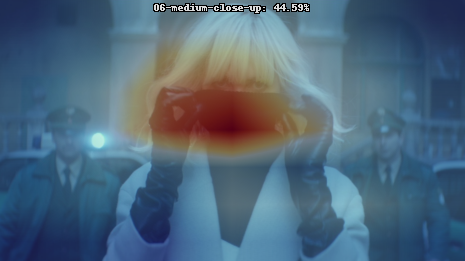

In [ ]:
f = "../assets/imgs/atomic-blonde.jpg"
learn.gradcam(f)

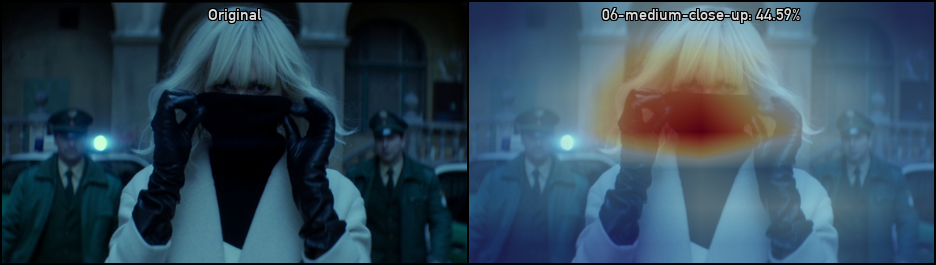

In [ ]:
learn.gradcam(f, labels=None, img_size=None, show_original=True, font_size=16, font_path="../fonts/DIN Alternate Bold.ttf")

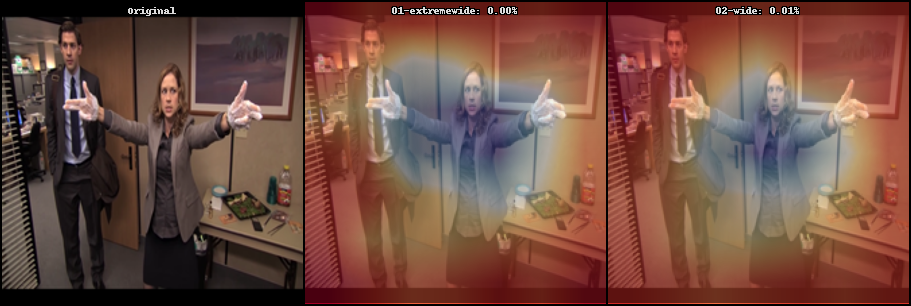

In [ ]:
f = get_image_files(path_imgs)[2]
learn.gradcam(f, labels=['01-extremewide', '02-wide'], img_size=(224,224), alpha=0.45, show_original=True)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_interpret_classification-interpretation.ipynb.
Converted 02_interpret_compare-models.ipynb.
Converted 03_interpret_gradcam.ipynb.
Converted 04_inference_export-to-other-frameworks.ipynb.
Converted 05_augment_PIL-img_filters.ipynb.
Converted index.ipynb.
